## Preprocessing the Images (Resizing, Greyscaling and Normalizing)

In [8]:
from PIL import Image

def preprocess_images(input_folder, output_folder, target_size=(128, 128)):
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Iterate through each image in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith('.png'):
            # Open the image file
            image_path = os.path.join(input_folder, filename)
            try:
                with Image.open(image_path) as img:
                    print(f"Processing image: {filename}, mode: {img.mode}, size: {img.size}")

                    # Resize the image to the target size
                    img = img.resize(target_size, Image.LANCZOS)

                    # Convert the image to grayscale
                    img = img.convert('L')

                    # Normalize pixel values to the range [0, 255]
                    img = img.point(lambda x: x / 255.0 * 255)

                    # Save the preprocessed image to the output folder
                    output_path = os.path.join(output_folder, filename)
                    img.save(output_path)

                    print(f"Saved preprocessed image: {output_path}")
            except Exception as e:
                print(f"Error processing image {filename}: {e}")

if __name__ == "__main__":
    input_folder = '/home/admin1/Desktop/GAN/piano_rolls'
    output_folder = '/home/admin1/Desktop/GAN/preprocessed_piano_rolls'
    preprocess_images(input_folder, output_folder)

Processing image: Give a Little Time to Your Love_piano_roll.png, mode: RGBA, size: (830, 527)
Saved preprocessed image: /home/admin1/Desktop/GAN/preprocessed_piano_rolls/Give a Little Time to Your Love_piano_roll.png
Processing image: Etudein A Minor Op27, No3_piano_roll.png, mode: RGBA, size: (830, 527)
Saved preprocessed image: /home/admin1/Desktop/GAN/preprocessed_piano_rolls/Etudein A Minor Op27, No3_piano_roll.png
Processing image: Sonata No 25 3rd_piano_roll.png, mode: RGBA, size: (830, 527)
Saved preprocessed image: /home/admin1/Desktop/GAN/preprocessed_piano_rolls/Sonata No 25 3rd_piano_roll.png
Processing image: Melodische Übungsstücke (No 2)_piano_roll.png, mode: RGBA, size: (830, 527)
Saved preprocessed image: /home/admin1/Desktop/GAN/preprocessed_piano_rolls/Melodische Übungsstücke (No 2)_piano_roll.png
Processing image: Kinderszenen (Scenes from Childhood) Op 15 12 Kind im Einschlummern (Child Falling Asleep)_piano_roll.png, mode: RGBA, size: (830, 527)
Saved preprocessed

## Create multiple folders for Train, Test and Validate Datasets and store the Preprocessed Images

In [12]:
import shutil
from sklearn.model_selection import train_test_split

# Define paths
data_folder = '/home/admin1/Desktop/GAN/preprocessed_piano_rolls'
train_folder = '/home/admin1/Desktop/GAN/train_preprocessed_piano_rolls'
val_folder = '/home/admin1/Desktop/GAN/val_preprocessed_piano_rolls'

# Create train and validation folders if they don't exist
if not os.path.exists(train_folder):
    os.makedirs(train_folder)
if not os.path.exists(val_folder):
    os.makedirs(val_folder)

# Copy preprocessed images to train and validation folders
image_files = os.listdir(data_folder)
train_files, val_files = train_test_split(image_files, test_size=0.2, random_state=42)

for file in train_files:
    src = os.path.join(data_folder, file)
    dst = os.path.join(train_folder, file)  # Specify full file path
    shutil.copy(src, dst)

for file in val_files:
    src = os.path.join(data_folder, file)
    dst = os.path.join(val_folder, file)  # Specify full file path
    shutil.copy(src, dst)

In [19]:
import os
import cv2
import numpy as np

# Define paths to your image directories
train_folder = '/home/admin1/Desktop/GAN/train_preprocessed_piano_rolls'
val_folder = '/home/admin1/Desktop/GAN/val_preprocessed_piano_rolls'

# Define image dimensions
image_height, image_width = 64, 64  # Adjust according to your requirements

# Function to load and preprocess images
def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (image_width, image_height))
        img = img.astype('float32') / 255.0  # Normalize pixel values
        images.append(img)
    return np.array(images)

# Load training and validation images
train_images = load_images(train_folder)
val_images = load_images(val_folder)

## Initialize the DCGAN model

In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Generator model
def build_generator(input_shape):
    model = models.Sequential()
    model.add(layers.Dense(8 * 8 * 256, use_bias=False, input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((8, 8, 256)))

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

# Discriminator model
def build_discriminator(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

# Define the input shape
input_shape = (100,)  # Input shape for the generator

# Build and compile the discriminator
discriminator = build_discriminator((64, 64, 3))  # Ensure discriminator accepts images of size 64x64 and 3 channels
discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
                      loss='binary_crossentropy', metrics=['accuracy'])

# Build the generator
generator = build_generator(input_shape)  # Ensure generator outputs images of size 64x64 and 3 channels

# Combined model (generator and discriminator)
z = layers.Input(shape=input_shape)
img = generator(z)
discriminator.trainable = False
validity = discriminator(img)

combined = models.Model(z, validity)
combined.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
                  loss='binary_crossentropy')

# Print model summaries
generator.summary()
discriminator.summary()
combined.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 16384)             1638400   
                                                                 
 batch_normalization_9 (Bat  (None, 16384)             65536     
 chNormalization)                                                
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 16384)             0         
                                                                 
 reshape_3 (Reshape)         (None, 8, 8, 256)         0         
                                                                 
 conv2d_transpose_9 (Conv2D  (None, 16, 16, 128)       819200    
 Transpose)                                                      
                                                                 
 batch_normalization_10 (Ba  (None, 16, 16, 128)      

## Start the Training Process

In [27]:
# Define some parameters
batch_size = 32
epochs = 1000
noise_dim = 100

# Function to generate noise
def generate_noise(batch_size, noise_dim):
    return np.random.normal(0, 1, (batch_size, noise_dim))

# Training loop
for epoch in range(epochs):
    # ---------------------
    #  Train Discriminator
    # ---------------------
    # Select a random batch of images
    idx = np.random.randint(0, train_images.shape[0], batch_size)
    real_imgs = train_images[idx]

    # Generate a batch of new images
    noise = generate_noise(batch_size, noise_dim)
    gen_imgs = generator.predict(noise)

    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(real_imgs, np.ones((batch_size, 1)))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((batch_size, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train Generator
    # ---------------------
    noise = generate_noise(batch_size, noise_dim)

    # The generator wants the discriminator to label the generated samples as valid
    valid_y = np.array([1] * batch_size)

    # Train the generator
    g_loss = combined.train_on_batch(noise, valid_y)

    # Print progress
    print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

1/1 [==============================] - 0s 29ms/step
0 [D loss: 0.492432, acc.: 100.00%] [G loss: 0.887542]
1/1 [==============================] - 0s 23ms/step
1 [D loss: 0.798759, acc.: 20.31%] [G loss: 0.506971]
1/1 [==============================] - 0s 22ms/step
2 [D loss: 0.507688, acc.: 100.00%] [G loss: 0.817829]
1/1 [==============================] - 0s 22ms/step
3 [D loss: 0.695066, acc.: 45.31%] [G loss: 0.605881]
1/1 [==============================] - 0s 22ms/step
4 [D loss: 0.590825, acc.: 81.25%] [G loss: 0.663210]
1/1 [==============================] - 0s 23ms/step
5 [D loss: 0.602788, acc.: 81.25%] [G loss: 0.744073]
1/1 [==============================] - 0s 21ms/step
6 [D loss: 0.676284, acc.: 51.56%] [G loss: 0.674227]
1/1 [==============================] - 0s 23ms/step
7 [D loss: 0.587499, acc.: 78.12%] [G loss: 0.693255]
1/1 [==============================] - 0s 21ms/step
8 [D loss: 0.618186, acc.: 81.25%] [G loss: 0.710922]
1/1 [==============================] - 0s 20

1/1 [==============================] - 0s 13ms/step


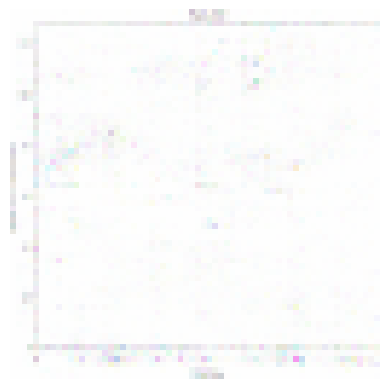

In [30]:
import matplotlib.pyplot as plt
import os

# Generate noise
noise = generate_noise(1, noise_dim)  # Assuming generate_noise function is defined elsewhere

# Generate an image
generated_image = generator.predict(noise)

# Rescale the image from [-1, 1] to [0, 1]
generated_image = 0.5 * generated_image + 0.5

# Display and save the image
plt.imshow(generated_image[0])
plt.axis('off')

# Save the image to a file
save_dir = '/home/admin1/Desktop/GAN/Output'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

plt.savefig(os.path.join(save_dir, 'generated_image1.png'), bbox_inches='tight', pad_inches=0)

plt.show()

## Convert the generated image into MIDI file as an output and save it

In [33]:
import numpy as np
from PIL import Image
from midiutil import MIDIFile

def image_to_midi(image_path, output_midi_path, threshold=0.5):
    # Load the image and convert it to grayscale
    img = Image.open(image_path).convert('L')

    # Convert the image to a numpy array and normalize it
    img_array = np.array(img) / 255.0

    # Threshold the image array
    img_array = (img_array > threshold).astype(int)  # Change here

    # Create a new MIDI file
    midi = MIDIFile(1)

    # Iterate over the image array
    for y in range(img_array.shape[1]):
        for x in range(img_array.shape[0]):
            # If the pixel is above the threshold, add a note to the MIDI file
            if img_array[x, y] == 1:
                # Map the x and y coordinates to MIDI pitch and velocity values
                pitch = int(60 + (x / img_array.shape[0]) * 36)  # Map x to MIDI pitch
                velocity = int(64 + (y / img_array.shape[1]) * 63)  # Map y to MIDI velocity

                # Add the note to the MIDI file
                midi.addNote(0, 0, pitch, velocity, 1, 100)


    # Write the MIDI file
    with open(output_midi_path, 'wb') as output_file:
        midi.writeFile(output_file)

# Convert the image to a MIDI file

img_path = '/home/admin1/Desktop/GAN/Output/generated_image1.png'
output_midi_path = '/home/admin1/Desktop/GAN/Output/output1.mid'

image_to_midi(img_path, output_midi_path)

In [35]:
from IPython.display import Audio

# Play the MIDI file
Audio('/home/admin1/Desktop/GAN/Output/output1.mid')